**Домашнее задание 1**:

Ссылка на наборы данных: https://drive.google.com/file/d/1j8zuKbI-PW5qKwhybP4S0EtugbPqmeyX/view?usp=sharing

**Задание 1**: Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;

In [1]:
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# большая чёткость графиков
#%config InlineBackend.figure_format = 'svg'
plt.savefig("High resoltion.png",dpi=600)
import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb

<Figure size 432x288 with 0 Axes>

Размерность датасетов:

In [87]:
train = pd.read_csv("../../data/kaggle/gb_kaggle/train.csv")
test = pd.read_csv("../../data/kaggle/gb_kaggle/test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


In [3]:
# show all columns
#pd.set_option('display.max_columns', None)

In [4]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


Базовые статистики

In [5]:
train.describe().round(1)

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,...,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0
mean,0.1,10.7,-1.6,10.7,6.8,11.1,-5.1,5.4,16.5,0.3,...,3.2,7.4,1.9,3.3,18.0,-0.1,2.3,8.9,15.9,-3.3
std,0.3,3.0,4.1,2.6,2.0,1.6,7.9,0.9,3.4,3.3,...,4.6,3.0,1.5,4.0,3.1,1.4,5.5,0.9,3.0,10.4
min,0.0,0.4,-15.0,2.1,-0.0,5.1,-32.6,2.3,5.3,-10.5,...,-14.1,-2.7,-3.8,-11.8,8.7,-5.3,-14.2,6.0,6.3,-38.9
25%,0.0,8.5,-4.7,8.7,5.3,9.9,-11.2,4.8,13.9,-2.3,...,-0.1,5.2,0.9,0.6,15.6,-1.2,-1.9,8.3,13.8,-11.2
50%,0.0,10.5,-1.6,10.6,6.8,11.1,-4.8,5.4,16.5,0.4,...,3.2,7.3,1.9,3.4,18.0,-0.2,2.4,8.9,15.9,-2.8
75%,0.0,12.8,1.4,12.5,8.3,12.3,0.9,6.0,19.1,2.9,...,6.4,9.5,2.9,6.2,20.4,0.8,6.6,9.6,18.1,4.8
max,1.0,20.3,10.4,19.4,13.2,16.7,17.3,8.4,27.7,10.2,...,18.4,16.7,8.4,18.3,27.9,4.3,18.3,12.0,26.1,28.5


In [95]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [6]:
test.describe().round(1)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,...,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0
mean,10.7,-1.6,10.7,6.8,11.1,-5.1,5.4,16.5,0.3,7.6,...,3.2,7.5,1.9,3.3,18.0,-0.1,2.3,8.9,15.9,-3.2
std,3.0,4.0,2.6,2.1,1.6,7.9,0.9,3.4,3.3,1.2,...,4.6,3.0,1.5,4.0,3.1,1.4,5.4,0.9,3.0,10.4
min,0.2,-15.0,2.4,-0.0,5.5,-27.8,2.2,5.7,-10.0,4.2,...,-14.1,-2.4,-3.3,-11.4,9.4,-4.9,-13.9,6.2,6.6,-39.5
25%,8.4,-4.7,8.7,5.2,9.9,-11.2,4.8,13.9,-2.3,6.6,...,-0.1,5.2,0.9,0.6,15.6,-1.2,-1.9,8.3,13.8,-11.1
50%,10.5,-1.6,10.6,6.8,11.1,-4.8,5.4,16.4,0.4,7.6,...,3.2,7.4,1.9,3.4,18.0,-0.2,2.4,8.9,15.9,-2.7
75%,12.7,1.3,12.5,8.3,12.3,0.9,6.0,19.1,2.9,8.6,...,6.3,9.5,3.0,6.2,20.4,0.8,6.5,9.6,18.0,4.9
max,22.3,9.4,18.7,13.1,16.0,17.3,8.3,28.3,9.7,11.0,...,20.4,16.7,8.0,17.6,27.9,4.5,15.9,12.3,26.5,27.9


In [7]:
# выберем только числовые признаки
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 201


Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

Категориальных признаков нет, все признаки - числовые.

Среди числовык признаков, все - дробные, следовательно числовые признаки непрерывные, дискретных нет.

Анализ пропусков

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB


In [10]:
# количество переменных с пропусками
len(train.columns[train.isnull().any()])

0

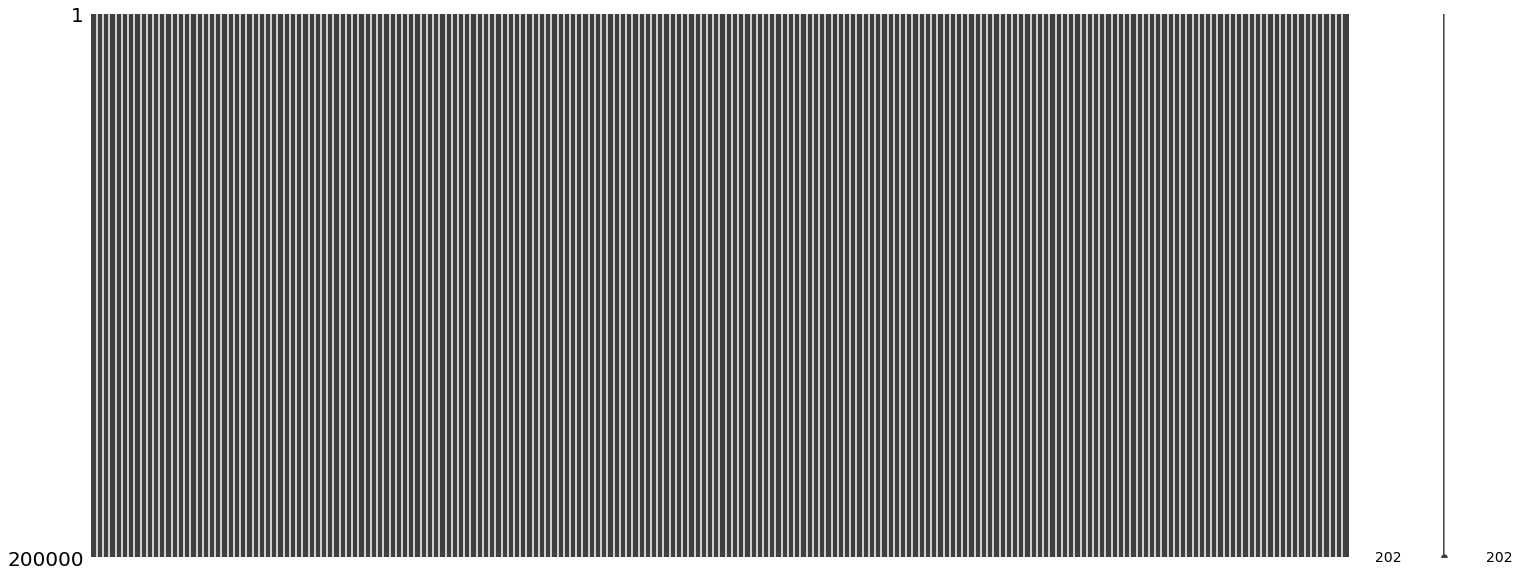

In [11]:
msno.matrix(train);

In [12]:
len(test.columns[test.isnull().any()])

0

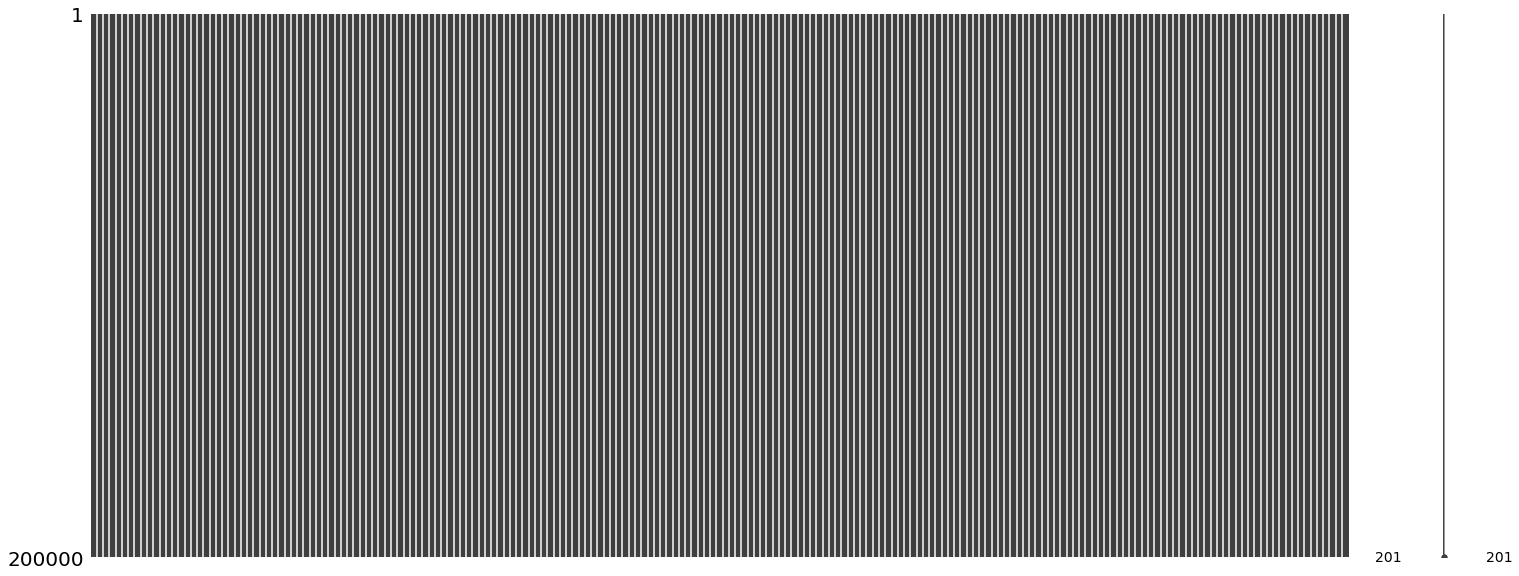

In [13]:
msno.matrix(test);

**Выводы**:
Пропусков в данных нет.

---

**Задание 2**: Сделать базовый анализ целевой переменной, сделать выводы;

In [14]:
train['target'].unique()

array([0, 1], dtype=int64)

Целевая переменная имеет два значения: 0 и 1. Следовательно мы имеем задачу классификации.

Проверим как распределена целевая переменная.

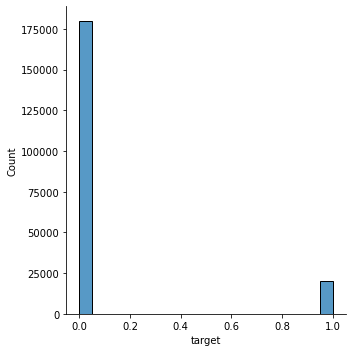

In [15]:
sns.displot(train, x='target');

__Вывод:__ целевая имеет **дисбаланс классов**. Это нужно учитывать при построении модели.

---

**Задание 3**: Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;

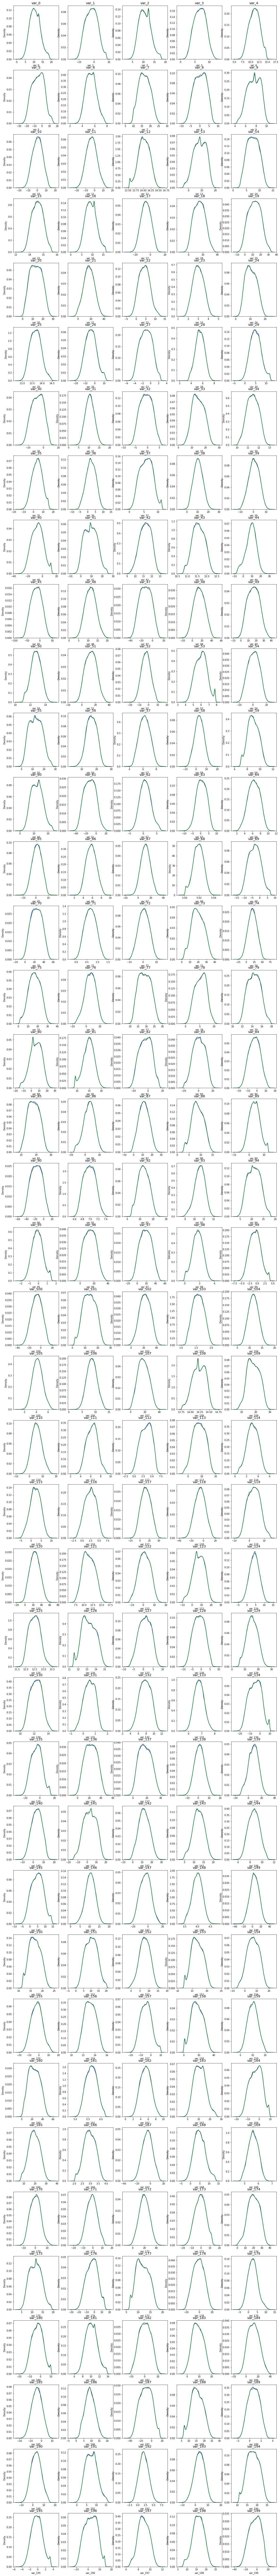

In [32]:
features = list(train.columns)[2:]
row_no, column_no = 40, 5
fig, axes = plt.subplots(row_no, column_no, figsize=(20, 200))

for num, feature in enumerate(features):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//column_no, num%column_no], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//column_no, num%column_no], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//column_no, num%column_no], color="blue", label="train")
    axes[num//column_no, num%column_no].set_title(feature, fontsize=14)

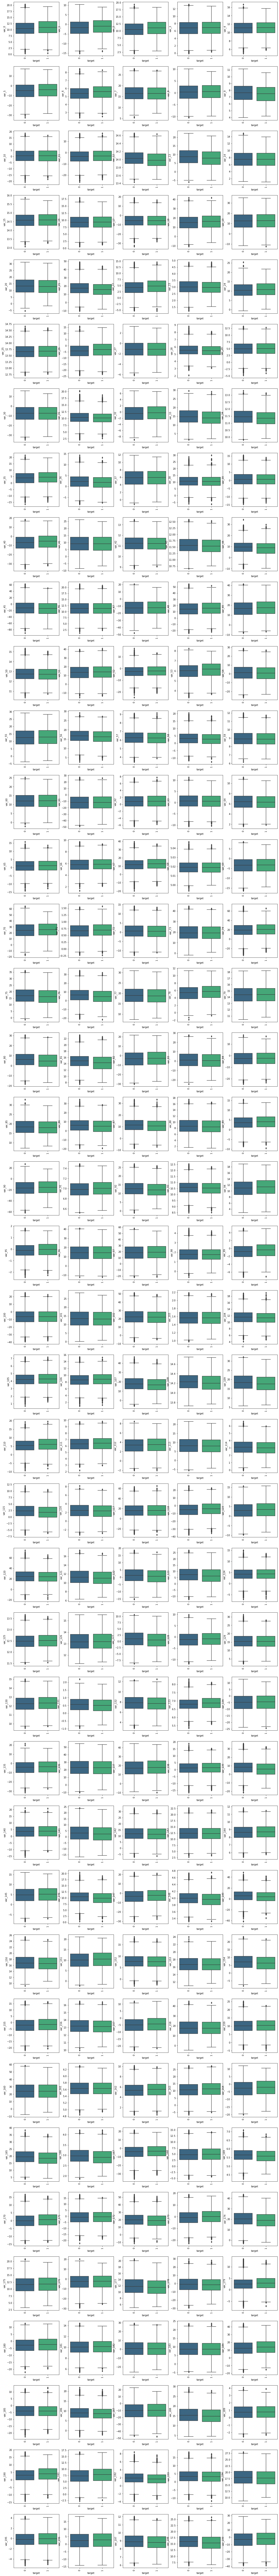

In [33]:
features = list(train.columns)[2:]
row_no, column_no = 40, 5
fig, axes = plt.subplots(row_no, column_no, figsize=(20, 200))
#targert = train[TARGET_NAME].copy()

for num, feature in enumerate(features):
    data = train[feature].copy()
    sns.boxplot(y=feature, x='target', data=train, palette="viridis", ax=axes[num//column_no, num%column_no]) 
    axes[num//column_no, num%column_no].tick_params(axis="x", rotation=90)

**Вывод**: распределения трейна и теста близки.

**Задание 4**: Построить распределение основных статистик признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;

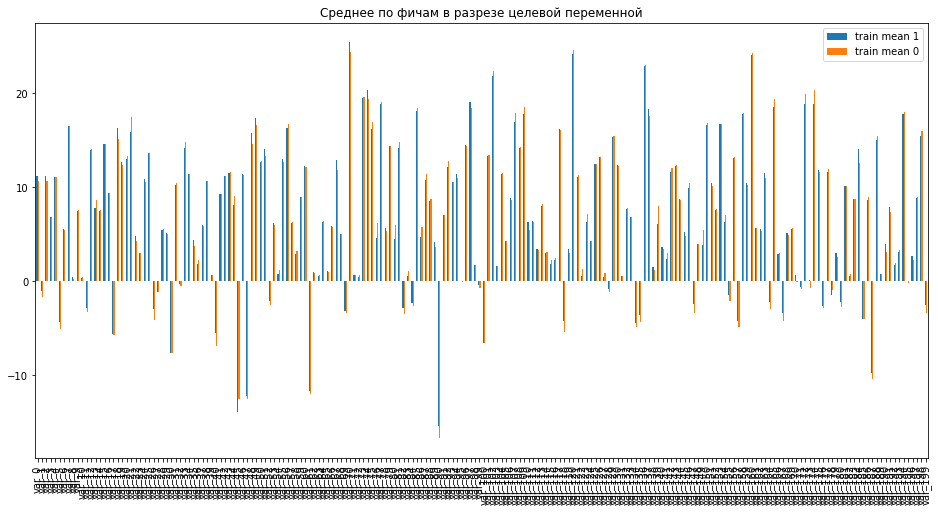

In [80]:
df = pd.DataFrame({
    # среднее по всем фичам трейна за исключением таргета
    'train mean 1': train.loc[train['target']==1, :].describe().iloc[1,1:],
    # среднее по всем фичам теста (здесь таргета нет)
    'train mean 0': train.loc[train['target']==0, :].describe().iloc[1,1:]
})

df.plot.bar(figsize=(16,8))
plt.title('Среднее по фичам в разрезе целевой переменной');

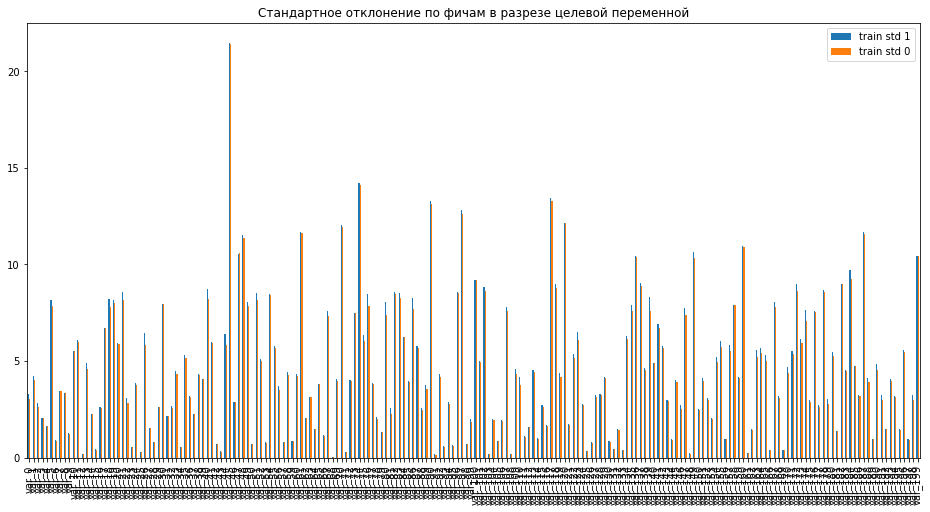

In [81]:
df = pd.DataFrame({
    # среднее по всем фичам трейна за исключением таргета
    'train std 1': train.loc[train['target']==1, :].describe().iloc[2,1:],
    # среднее по всем фичам теста (здесь таргета нет)
    'train std 0': train.loc[train['target']==0, :].describe().iloc[2,1:]
})

df.plot.bar(figsize=(16,8))
plt.title('Стандартное отклонение по фичам в разрезе целевой переменной');

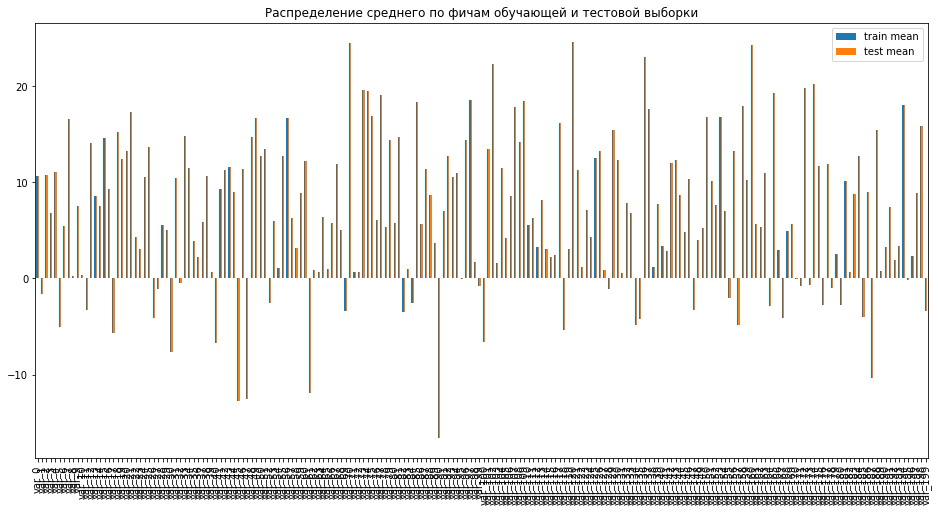

In [82]:
df = pd.DataFrame({
    # среднее по всем фичам трейна за исключением таргета
    'train mean': train.describe().iloc[1,1:],
    # среднее по всем фичам теста (здесь таргета нет)
    'test mean': train.describe().iloc[1,1:]
})

df.plot.bar(figsize=(16,8))
plt.title('Распределение среднего по фичам обучающей и тестовой выборки');

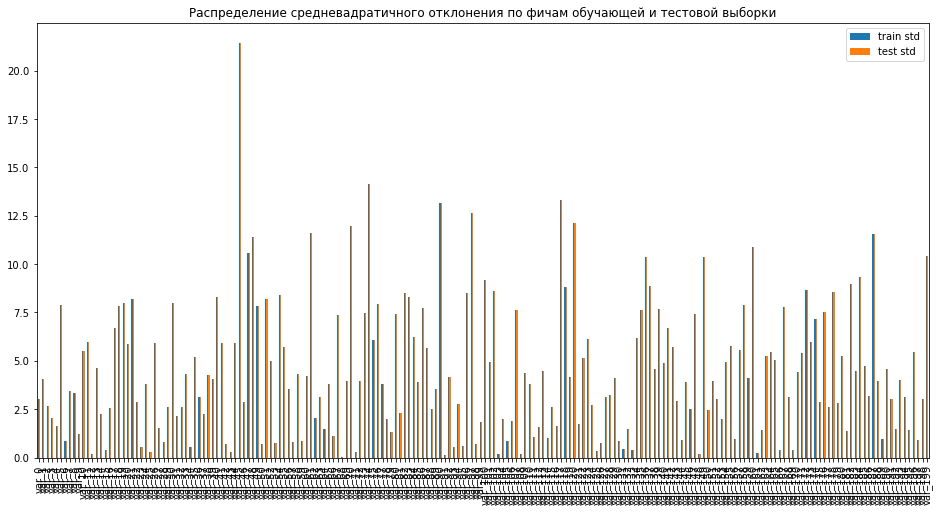

In [83]:
df = pd.DataFrame({
    # среднее по всем фичам трейна за исключением таргета
    'train std': train.describe().iloc[2,1:],
    # среднее по всем фичам теста (здесь таргета нет)
    'test std': train.describe().iloc[2,1:]
})

df.plot.bar(figsize=(16,8))
plt.title('Распределение средневадратичного отклонения по фичам обучающей и тестовой выборки');

**Вывод**: распределение классов и тестовой/трейновой выборок в целом похожи.

**Задание 5**: Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?

Text(0, 0.5, 'Density')

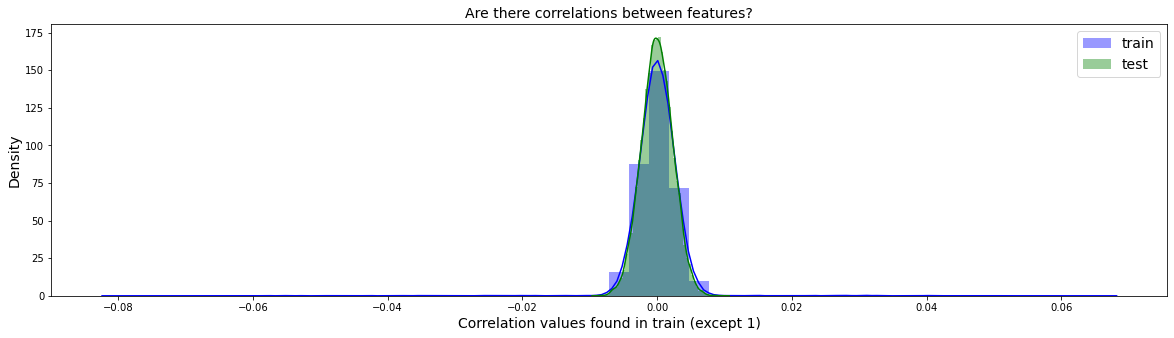

In [90]:
train_correlations = train.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = numerical_features.columns.tolist()
columns.remove("target")

test_correlations = test[columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

Видим, что выделяются 5 признаков с максимальной коррелицией.

<AxesSubplot:title={'center':'Correlation of Numeric Features with Sale Price'}>

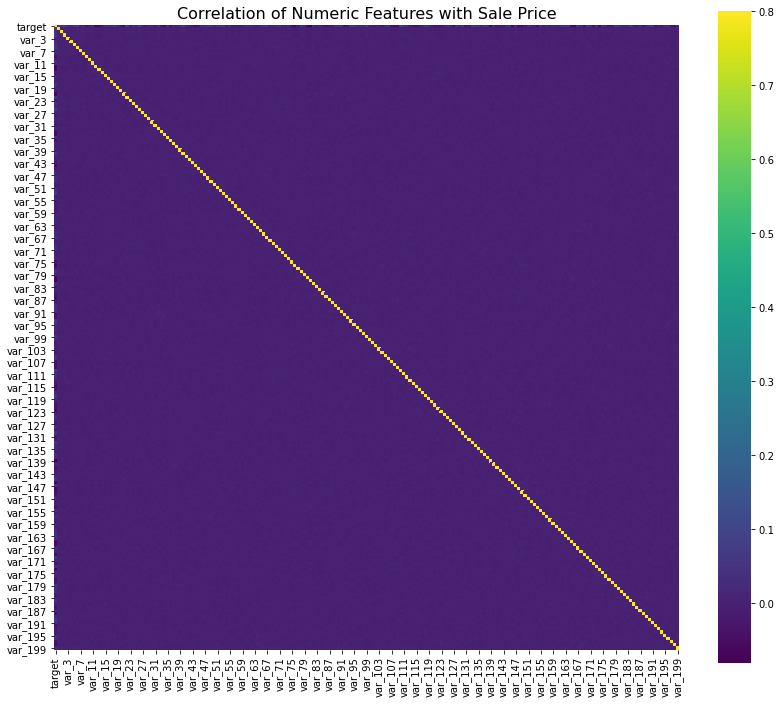

In [91]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

Построим плот корреляции 5-ти признаков с самой высокой корреляцией.

<AxesSubplot:>

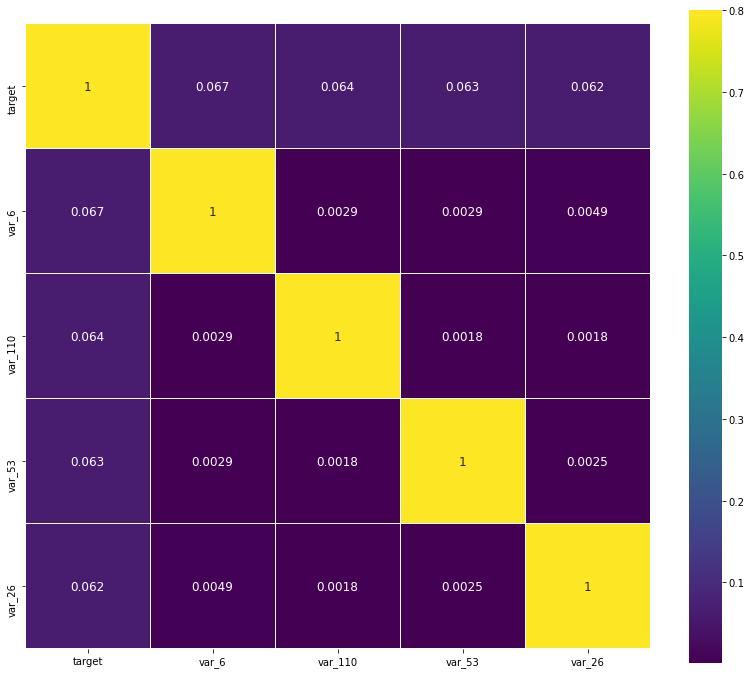

In [92]:
k = 5
cols = correlation.nlargest(k, "target")["target"].index
cm = np.corrcoef(train[cols].values.T)
fig, axes = plt.subplots(figsize = (14, 12))

sns.heatmap(
    cm,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=cols.values,
    annot_kws = {"size": 12},
    yticklabels=cols.values
)

**Вывод**: нет ни одного признака с линейной корреляцией выше 0,2. Данные плохо коррелируют (линейно) с целевой переменной.

**Задание 6**: Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

In [92]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 8}

forest = RandomForestRegressor(**parameters)
forest.fit(train.drop(['target', 'ID_code'], axis=1), train['target'])

Wall time: 2min 33s


RandomForestRegressor(max_depth=6, n_estimators=25, n_jobs=8, random_state=27)

Text(0.5, 1.0, 'What are the top important features to start with?')

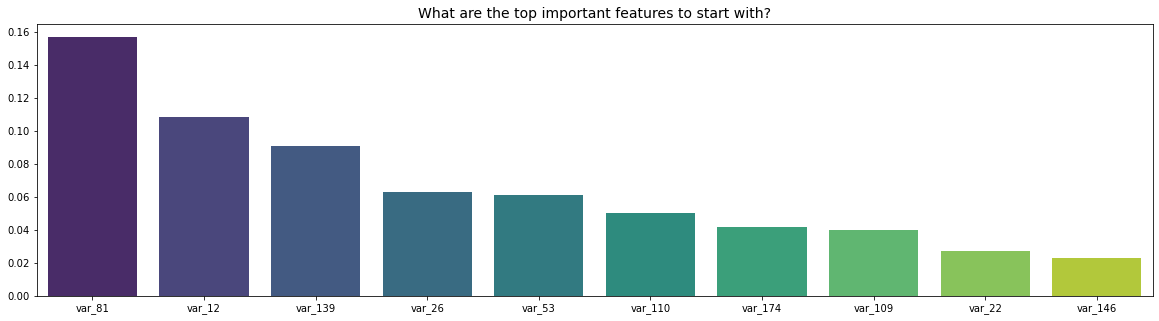

In [93]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = train.drop(['target', 'ID_code'], axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

---

**Задание 7 (опция)**: Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

In [100]:
features_to_score_train = train.drop(['target', 'ID_code'], axis=1).columns.tolist()
features_to_score_test = test.drop('ID_code', axis=1).columns.tolist()

X_adv = pd.concat([
    train[features_to_score_train],
    test[features_to_score_test]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [101]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 8}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

[23:35:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:37:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:38:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV-score: 0.5116
Wall time: 4min 15s


[23:39:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

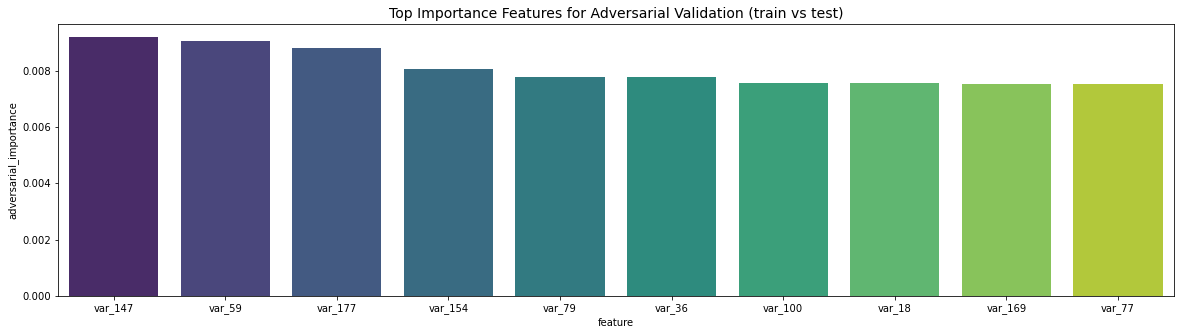

In [102]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)